# Blending

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

### 导入数据

In [7]:
from sklearn.datasets import load_iris

In [8]:
data = load_iris()

In [9]:
X = data.data[:,1:3]
y = data.target
print(X.shape,y.shape)

(150, 2) (150,)


### 数据划分

In [20]:
from sklearn.model_selection import train_test_split

X_train_,X_test,y_train_,y_test = train_test_split(X,y,test_size = 0.2)

X_train,X_val,y_train,y_val = train_test_split(X_train_,y_train_)

In [21]:
print(X_train.shape,X_val.shape,X_test.shape)

(90, 2) (30, 2) (30, 2)


### 第一层分类器

In [22]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

clfs = [SVC(probability = True),DecisionTreeClassifier(),KNeighborsClassifier()]


In [23]:
# 输出第一层的验证集结果与测试集结果
val_features = np.zeros((X_val.shape[0],len(clfs)))  # 初始化验证集结果
test_features = np.zeros((X_test.shape[0],len(clfs)))  # 初始化测试集结果

for i,clf in enumerate(clfs):
    clf.fit(X_train,y_train)
    val_feature = clf.predict_proba(X_val)[:, 1]
    test_feature = clf.predict_proba(X_test)[:,1]
    val_features[:,i] = val_feature
    test_features[:,i] = test_feature

### 第二层分类器

In [24]:
# 设置第二层分类器
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# 将第一层的验证集的结果输入第二层训练第二层分类器
lr.fit(val_features,y_val)
# 输出预测的结果
from sklearn.model_selection import cross_val_score
cross_val_score(lr,test_features,y_test,cv=5)

array([0.83333333, 0.66666667, 0.66666667, 0.83333333, 0.66666667])

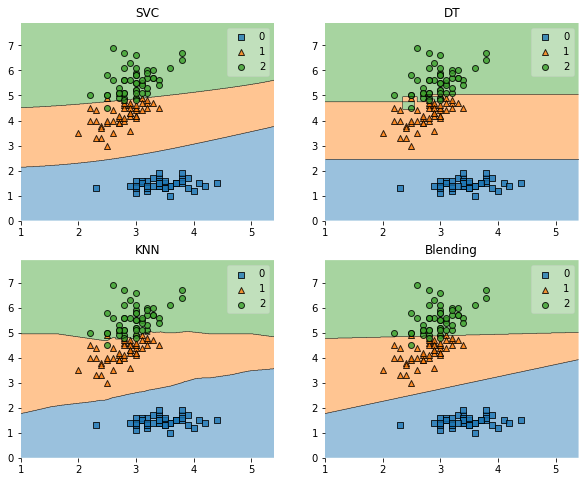

In [27]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
clfs.append(lr)
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip(clfs, 
                         ['SVC', 
                          'DT', 
                          'KNN',
                          'Blending'],
                          itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

# stacking

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

### 模型训练

In [10]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier()
clf3 = GaussianNB()
lr = LogisticRegression()


clf_stacking = StackingCVClassifier(classifiers=[clf1,clf2,clf3],
                                   meta_classifier=lr,
                                   cv=5)
for clf, label in zip([clf1, clf2, clf3, clf_stacking], ['KNN', 'Random Forest', 'Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.96 (+/- 0.02) [StackingClassifier]


### 决策边界

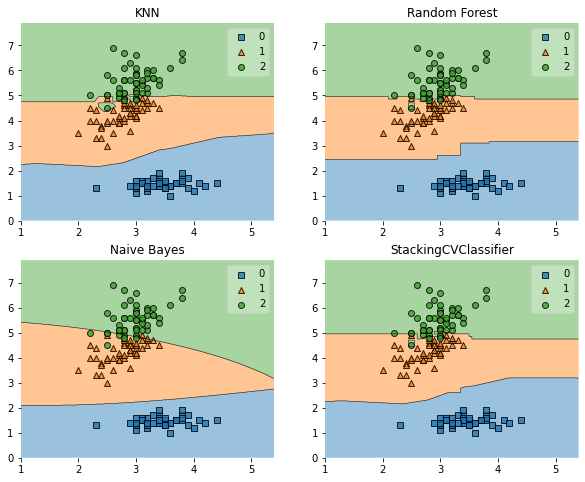

In [18]:
from mlxtend.plotting import plot_decision_regions
from matplotlib import gridspec
import itertools

gs = gridspec.GridSpec(2,2)
fig =  plt.figure(figsize=(10,8))

for clf,lab,grd in zip([clf1,clf2,clf3,clf_stacking],
                      ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingCVClassifier'],
                       itertools.product([0,1],repeat=2)
                      ):
    clf.fit(X,y)
    ax = plt.subplot(gs[grd[0],grd[1]])
    fig = plot_decision_regions(X=X,y=y,clf=clf)
    plt.title(lab)
plt.show()

### 网格调参

In [20]:
from sklearn.model_selection import GridSearchCV

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=clf_stacking, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
Accuracy: 0.95


In [22]:
clf_stacking.score(X,y)

0.9866666666666667

### 基模型使用不同的特征子集

In [23]:
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector
iris = load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),  # 选择第0,2列
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),  # 选择第1,2,3列
                      LogisticRegression())

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2], 
                            meta_classifier=LogisticRegression(),
                            random_state=42)

sclf.fit(X, y)

StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 2))),
                                                  ('logisticregression',
                                                   LogisticRegression())]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(1, 2,
                                                                        3))),
                                                  ('logisticregression',
                                                   LogisticRegression())])],
                     meta_classifier=LogisticRegression(), random_state=42)

In [24]:
from sklearn.model_selection import cross_val_score
cross_val_score(sclf,X,y,cv=5)

array([0.96666667, 0.96666667, 0.9       , 0.96666667, 1.        ])